# Introduction to Code Generation

This notebook exemplifies how to generate automatically code in terms of interfaces. For this three examples are provided. The first one creates a ROS message, the second a standard python class and the last a protobuf interface.

In [1]:
import capellambse
import capellambse.metamodel as mm

In [2]:
path_to_model = "../../../tests/data/melodymodel/5_0/Melody Model Test.aird"
model = capellambse.MelodyModel(path_to_model)

In particular, we want to create code from our class:

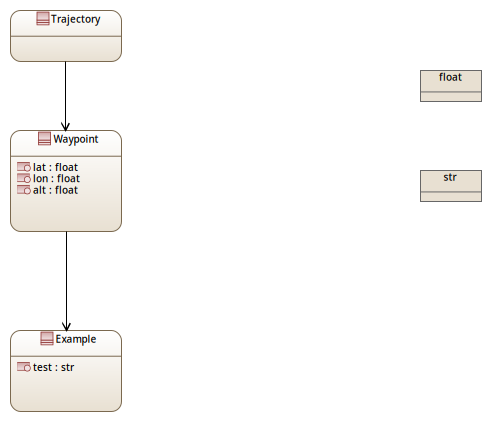

In [3]:
model.diagrams.by_name("[CDB] CodeGeneration")

In order to access the classes, we can simply access the `data_package` of the operational layer, and from there access the attribute `classes`.

In [4]:
data_pkg = model.oa.data_package
data_pkg.classes

[0] <Class 'Twist' (8164ae8b-36d5-4502-a184-5ec064db4ec3)>
[1] <Class 'Trajectory' (c5ea0585-7657-4764-9eb2-3a6584980ce6)>
[2] <Class 'Waypoint' (2a923851-a4ca-4fd2-a4b3-302edb8ac178)>
[3] <Class 'Example' (a7ecc231-c55e-4ab9-ae14-9558e3ec2a34)>

## ROS2 IDL Message

Let's have a brief look into the structure of ROS2 Message descriptions. They are stored in `.msg` files and comprised of a type and name, separated by whitespace, i.e.:

```
fieldtype1 fieldname1
fieldtype2[] fieldname2
```

In [5]:
def class_to_ros2_idl(cls):
    filename = f"{cls.name}.msg"
    lines = []
    for prop in cls.properties:
        multiplicity = "[]" * (prop.max_card.value not in ("0", "1"))
        lines.append(f"{prop.type.name}{multiplicity} {prop.name}")
    text = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(text)
    print(f"# file: {filename} \n{text}\n")

In our example, files would be generated with the following content:

In [6]:
data_pkg = model.oa.data_package
for cls in data_pkg.classes:
    class_to_ros2_idl(cls)

# file: Twist.msg 


# file: Trajectory.msg 
Waypoint[] waypoints

# file: Waypoint.msg 
float lat
float lon
float alt
Example[] examples

# file: Example.msg 
str test



## Interface for python classes

A python class has the following structure:


```
class class_name:
    name1: type  
    name2: [type]
```

A python interface can be generated as follows:

In [7]:
def class_to_python(cls, current_classes=None):
    lines = [f"class {cls.name}:"]
    current_classes = [cls]
    if not cls.properties:
        lines.append(4 * " " + "pass")
    for prop in cls.properties:
        if (
            isinstance(prop.type, mm.information.Class)
            and prop.type not in current_classes
        ):
            nested_text = class_to_python(prop.type, current_classes)
            lines = [nested_text] + ["\n"] + lines
        if prop.max_card.value in ("0", "1"):
            multiplicity = prop.type.name
        else:
            multiplicity = f"list[{prop.type.name}]"
        lines.append(4 * " " + f"{prop.name}: {multiplicity}")
    return "\n".join(lines)

In [8]:
trajectory = data_pkg.classes.by_name("Trajectory")
text = class_to_python(trajectory)
filename = f"{trajectory.name.lower()}.py"
with open(filename, "w") as file:
    file.write(text)
print(f"# file: {filename} \n{text}\n")

# file: trajectory.py 
class Example:
    test: str


class Waypoint:
    lat: float
    lon: float
    alt: float
    examples: list[Example]


class Trajectory:
    waypoints: list[Waypoint]



## Interface for Protocol Buffers (Protobuf) 

Protobuf Message descriptions are stored in `.proto` files where a class definition starts with `message` and each property of the class is defined by at least three parts: the data type, name and its order number. Classes can also be nested in other classes. An example is shown in the following:


```
syntax = "proto3";

message class1 {
    datatype class1_name1 = 1;
    datatype class1_name2 = 2;
    message class2 {
        datatype class2_name1 = 1;
   }
   repeated class2 class_name = 3;
}

```


In [9]:
def class_to_proto(cls, current_classes=None, indent=""):
    if current_classes is None:
        current_classes = [cls]
        lines = ['syntax = "proto3";\n']
        indent += " " * 4
        lines.append(f"{indent[:-4]}message  {cls.name} {{")
    else:
        lines = [f"{indent[:-4]}message  {cls.name} {{"]

    for counter, prop in enumerate(cls.properties, start=1):
        multiplicity = "[]" * (prop.max_card.value not in ("0", "1"))
        if (
            isinstance(prop.type, mm.information.Class)
            and prop.type not in current_classes
        ):
            current_classes.append(prop.type)
            nested_text = class_to_proto(
                prop.type, current_classes, indent + " " * 4
            )
            lines.append(nested_text)
            lines.append(
                f"{indent}repeated {prop.type.name}{multiplicity} {prop.name} = {counter};"
            )
        else:
            lines.append(
                f"{indent}{prop.type.name}{multiplicity} {prop.name} = {counter};"
            )
    lines.append(f"{indent[:-4]}}}")
    return "\n".join(lines)

The protobuf interface of class `Trajectory` would look as follows:


In [10]:
trajectory = data_pkg.classes.by_name("Trajectory")
text = class_to_proto(trajectory)
filename = f"{trajectory.name}.proto"
with open(filename, "w") as file:
    file.write(text)
print(f"# file: {filename} \n{text}\n")

# file: Trajectory.proto 
syntax = "proto3";

message  Trajectory {
    message  Waypoint {
        float lat = 1;
        float lon = 2;
        float alt = 3;
        message  Example {
            str test = 1;
        }
        repeated Example[] examples = 4;
    }
    repeated Waypoint[] waypoints = 1;
}

